# **K-means on images**

Use the following images:
 - [image1.jpeg](https://drive.google.com/file/d/1ehjQbNbSLTPOdnzZf5mtcokH-Irb9Hsq/view?usp=sharing)


In [1]:
#Image segmentation from video using OpenCV and K-means clustering
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

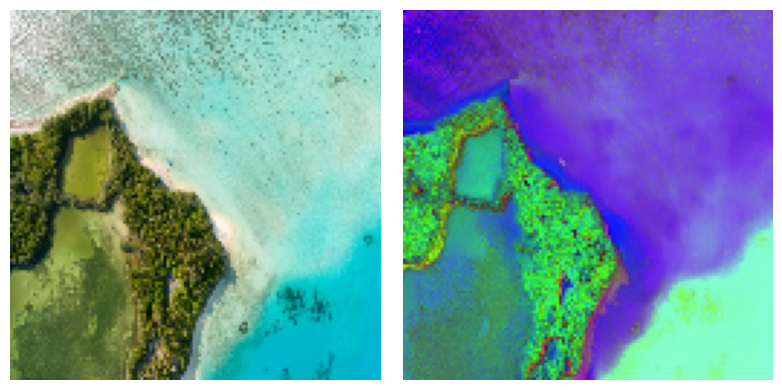

In [2]:
original_image = cv2.imread("/content/image1.jpeg")

# Resize to a feasible size to avoid extensive computation
original_image = cv2.resize(original_image, (128, 128))

# Convert from BGR Color Space to HSV
img_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV_FULL)

_, axes = plt.subplots (1, 2, figsize = (8,4))
axes[0].imshow( img_rgb ), axes[0].set_axis_off() #RGB
axes[1].imshow( img_hsv ), axes[1].set_axis_off() #HSV
plt.tight_layout()

In [3]:
# Vectorize to compute kmeans
vectorized_rgb = img_rgb.reshape([-1,3])
vectorized_rgb = np.float32(vectorized_rgb)

vectorized_hsv = img_hsv[:, :, 0].reshape([-1,1])
vectorized_hsv = np.float32(vectorized_hsv)

# Check both vector sizes
print(vectorized_rgb.shape, vectorized_hsv.shape)

(16384, 3) (16384, 1)


## **RGB image**

In [4]:
# Train kmeans
n = 3
kmeans = KMeans(n_clusters = n, random_state=0)
kmeans.fit( vectorized_rgb )

KMeans(n_clusters=3, random_state=0)

In [5]:
# Predict to segment regions
clustered_rgb = kmeans.predict( vectorized_rgb )
clustered_rgb = clustered_rgb.reshape( [img_rgb.shape[0], img_rgb.shape[1]] )

print(vectorized_rgb.shape, img_rgb.shape, clustered_rgb.shape)

(16384, 3) (128, 128, 3) (128, 128)


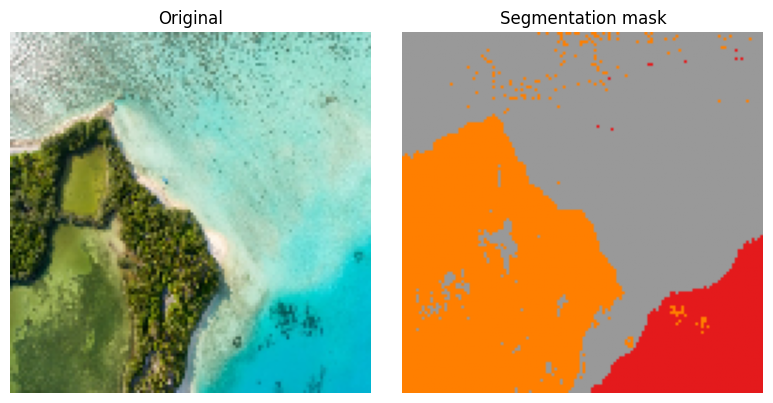

In [6]:
# Plot original and segmentation masks
_, axes = plt.subplots (1, 2, figsize = (8,4))

axes[0].set_title("Original"), axes[0].imshow( img_rgb ), axes[0].set_axis_off()
axes[1].set_title("Segmentation mask"), axes[1].imshow( clustered_rgb, cmap='Set1'), axes[1].set_axis_off()

plt.tight_layout()

(<matplotlib.image.AxesImage at 0x7cd0d2d36350>,
 None,
 Text(0.5, 1.0, 'Segmentation'))

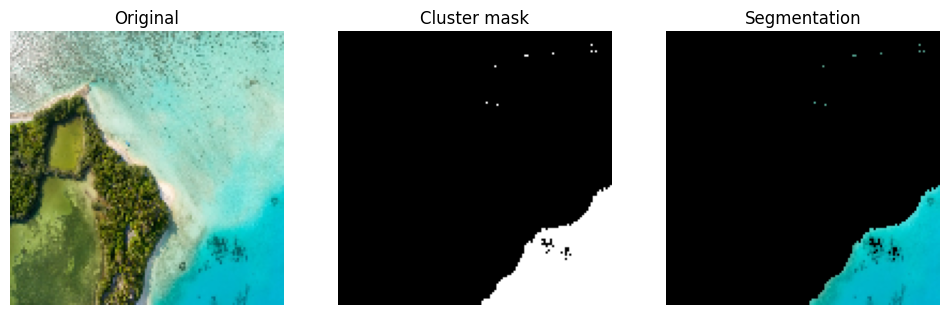

In [7]:
# Mask only the cluster number 0 (turn the rest of pixels into black)
cluster = 0

cluster_mask = np.array ( clustered_rgb == cluster , dtype = np.uint8)

masked_image = np.copy(img_rgb)
masked_image = cv2.bitwise_and(masked_image, masked_image, mask = cluster_mask)

_, axes = plt.subplots (1, 3, figsize = (12,4))
axes[0].imshow( img_rgb ), axes[0].set_axis_off(), axes[0].set_title("Original")
axes[1].imshow( cluster_mask , cmap="gray"), axes[1].set_axis_off(), axes[1].set_title("Cluster mask")
axes[2].imshow( masked_image ), axes[2].set_axis_off(), axes[2].set_title("Segmentation")

## **HSV image**

In [8]:
# Train kmeans
n = 4
kmeans = KMeans(n_clusters = n, random_state=0).fit( vectorized_hsv )

In [9]:
# Predict to segment regions
clustered_hsv = kmeans.predict( vectorized_hsv )
clustered_hsv = clustered_hsv.reshape( [img_hsv.shape[0], img_hsv.shape[1]] )

print(vectorized_hsv.shape, img_hsv.shape, clustered_hsv.shape)

(16384, 1) (128, 128, 3) (128, 128)


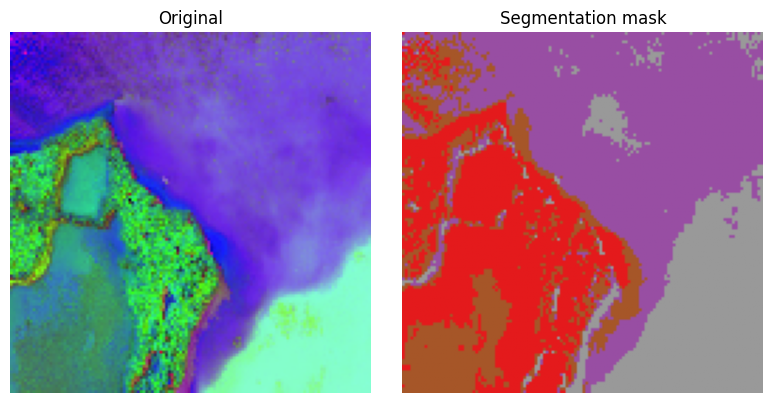

In [10]:
# Plot original and segmentation masks
_, axes = plt.subplots (1, 2, figsize = (8,4))
axes[0].imshow( img_hsv ), axes[0].set_axis_off(), axes[0].set_title("Original")
axes[1].imshow( clustered_hsv, cmap='Set1' ), axes[1].set_axis_off(), axes[1].set_title("Segmentation mask")
plt.tight_layout()

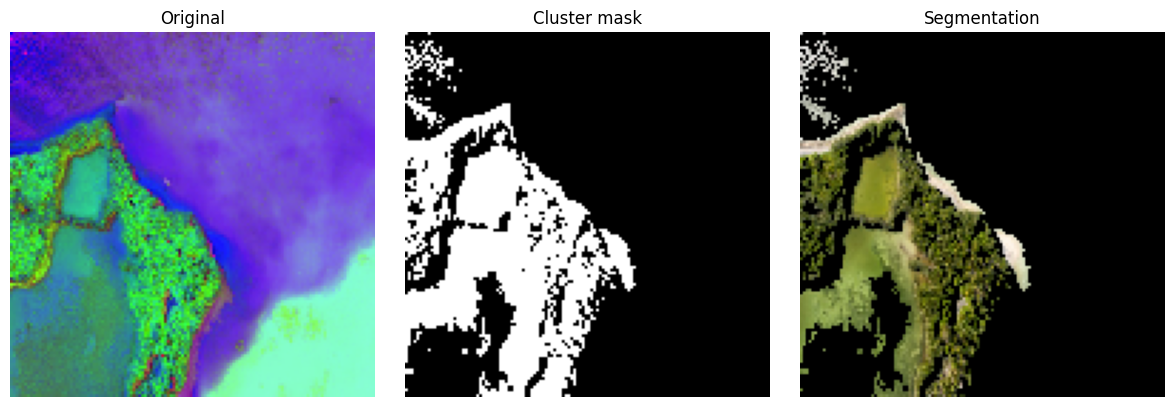

In [11]:
# Mask only the cluster number 0 (turn the rest of pixels into black)
cluster = 0

cluster_mask = np.array ( clustered_hsv == cluster , dtype = np.uint8)

masked_image = np.copy(img_rgb)
masked_image = cv2.bitwise_and(masked_image, masked_image, mask = cluster_mask)

_, axes = plt.subplots (1, 3, figsize = (12,4))
axes[0].imshow( img_hsv ), axes[0].set_axis_off(), axes[0].set_title("Original")
axes[1].imshow( cluster_mask , cmap="gray"), axes[1].set_axis_off(), axes[1].set_title("Cluster mask")
axes[2].imshow( masked_image ), axes[2].set_axis_off(), axes[2].set_title("Segmentation")
plt.tight_layout()

## **Comparison**

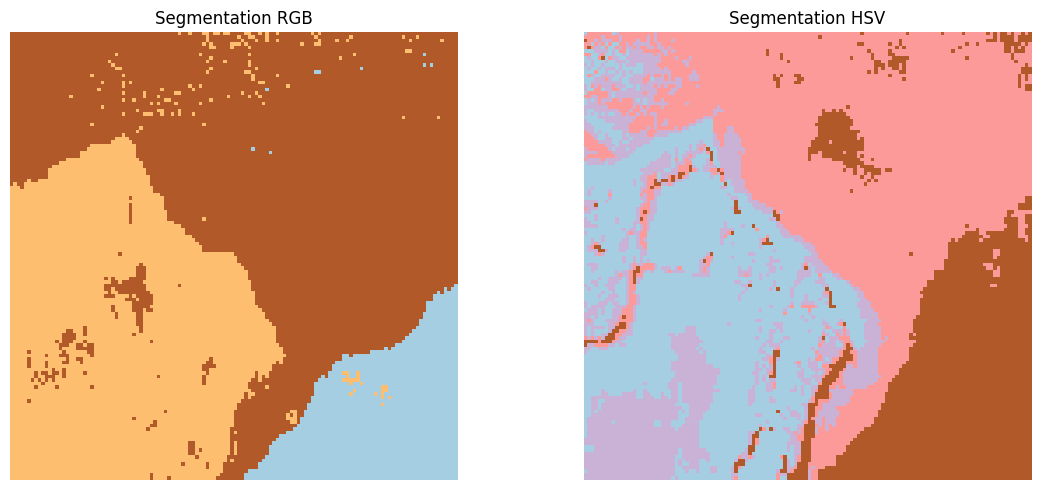

In [12]:
_, axes = plt.subplots (1, 2, figsize = (12,5))
axes[0].imshow(clustered_rgb, cmap="Paired"), axes[0].set_axis_off(), axes[0].set_title("Segmentation RGB")
axes[1].imshow(clustered_hsv, cmap="Paired"), axes[1].set_axis_off(), axes[1].set_title("Segmentation HSV")
plt.tight_layout()

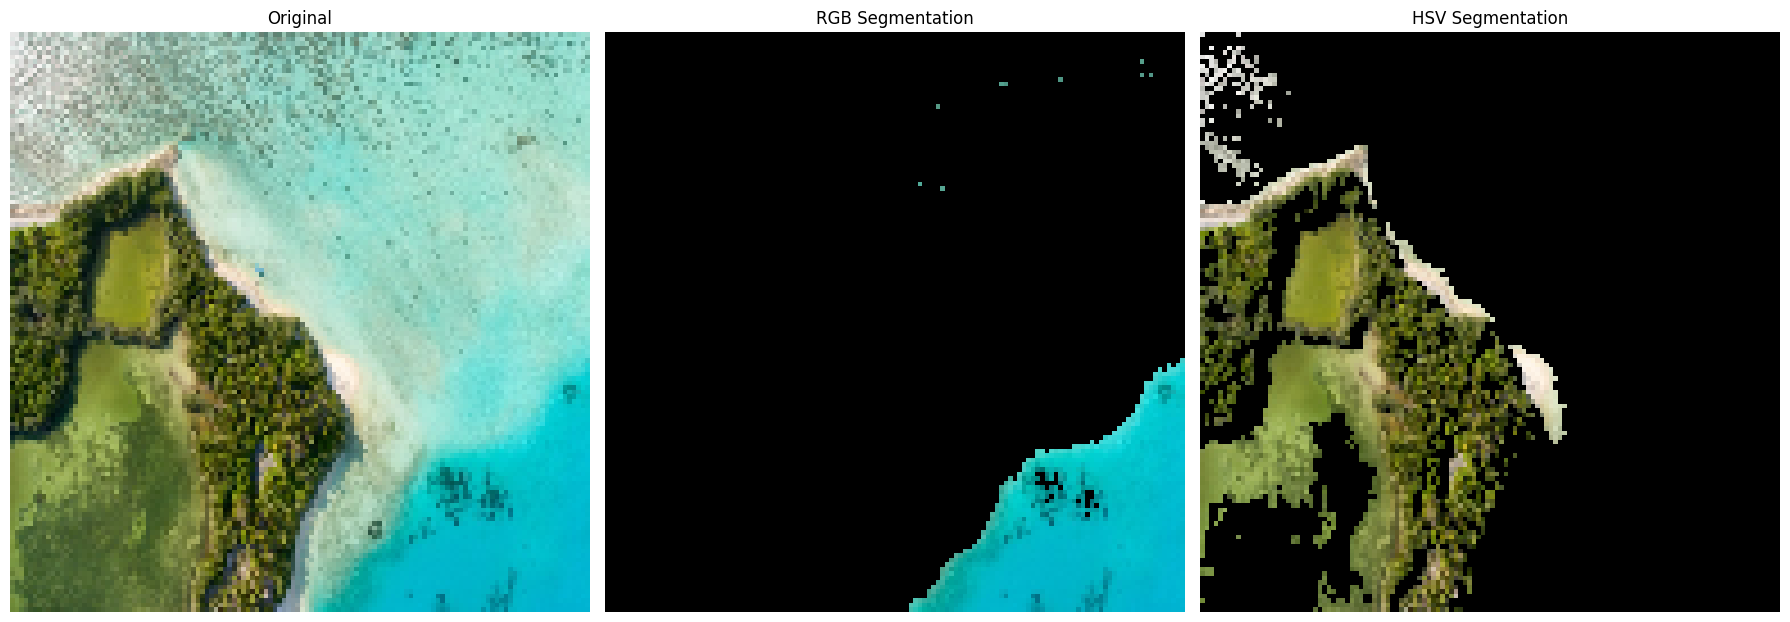

In [13]:
# Mask clusters (turn the rest of pixels into black)
cluster = 0
cluster_mask_rgb = np.array ( clustered_rgb == cluster , dtype = np.uint8)

cluster = 0
cluster_mask_hsv = np.array ( clustered_hsv == cluster , dtype = np.uint8)

masked_rgb = np.copy(img_rgb)
masked_rgb = cv2.bitwise_and(masked_rgb, masked_rgb, mask = cluster_mask_rgb )

masked_hsv = np.copy(img_rgb)
masked_hsv = cv2.bitwise_and(masked_hsv, masked_hsv, mask = cluster_mask_hsv )

_, axes = plt.subplots (1, 3, figsize = (18,8))
axes[0].imshow(img_rgb), axes[0].set_axis_off(), axes[0].set_title("Original")
axes[1].imshow(masked_rgb), axes[1].set_axis_off(), axes[1].set_title("RGB Segmentation")
axes[2].imshow(masked_hsv), axes[2].set_axis_off(), axes[2].set_title("HSV Segmentation")
plt.tight_layout()

# **Elbow and Silhouette**

Perform an analysis based on elbow and silhouette to determine the best number of clusters

In [14]:
def silhouette_score_def(clusters, vectorized):
  from sklearn.metrics import silhouette_score

  # Define num of clusters
  silhouette_distances = []

  # Eval kmeans over each num of clusters
  for cluster in clusters :
    kmeans = KMeans(n_clusters = cluster )
    kmeans.fit( vectorized )

    predictions = kmeans.predict( vectorized )
    distance = silhouette_score( vectorized , predictions , metric="euclidean")

    silhouette_distances.append(distance)
  return silhouette_distances

In [15]:
# Create a distance function
def euclidean_distance(pt1, pt2):
  squared_diffs = [(a - b)**2 for a, b in zip(pt1, pt2)]
  return sum(squared_diffs)**0.5

In [16]:
def elbow_distances_def(clusters, vectorized):
  # Define num of clusters
  elbow_distances = []

  # Eval kmeans over each num of clusters
  for cluster in clusters :
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit( vectorized )

    centroides = kmeans.cluster_centers_
    predictions = kmeans.predict( vectorized )
    distance = 0

    for i in range(len(vectorized)) :
      centroide = centroides[predictions[i]]
      distance += euclidean_distance( centroide , vectorized[i] )

    elbow_distances.append(distance/len(vectorized))
  return elbow_distances

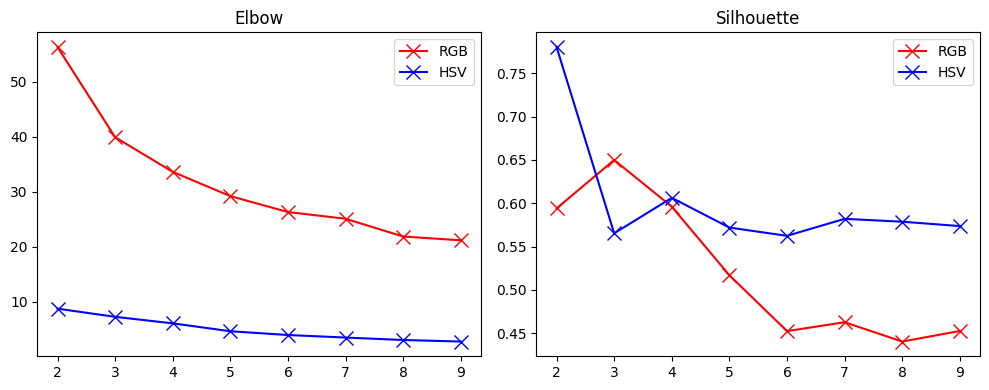

In [17]:
# Plot the elbow
clusters = [ 2, 3, 4, 5, 6, 7, 8, 9 ]
_, axes = plt.subplots (1,2, figsize = (10,4))

axes[0].plot( clusters, elbow_distances_def(clusters, vectorized_rgb), c='r', marker="x", ms=10, label="RGB")
axes[0].plot( clusters, elbow_distances_def(clusters, vectorized_hsv), c='b', marker="x", ms = 10, label="HSV")
axes[0].set_title("Elbow"), axes[0].legend()

axes[1].plot( clusters, silhouette_score_def(clusters, vectorized_rgb), c='r', marker="x", ms = 10, label="RGB")
axes[1].plot( clusters, silhouette_score_def(clusters, vectorized_hsv), c ='b', marker="x", ms = 10, label="HSV")
axes[1].set_title("Silhouette"), axes[1].legend()

plt.tight_layout()

# **In random images**


Repeat the segmentation with the following images:
 - [fr1.png](https://drive.google.com/file/d/18OR0DEx-rXeVBeqgbZqhzXXyOQhMyefb/view?usp=sharing)
 - [fr2.png](https://drive.google.com/file/d/1ehjQbNbSLTPOdnzZf5mtcokH-Irb9Hsq/view?usp=sharing)
 - [fr3.jpeg](https://drive.google.com/file/d/1ehjQbNbSLTPOdnzZf5mtcokH-Irb9Hsq/view?usp=sharing)
 - [fr4.jpeg](https://drive.google.com/file/d/1ehjQbNbSLTPOdnzZf5mtcokH-Irb9Hsq/view?usp=sharing)
